In [164]:
import numpy as np
import matplotlib.pyplot as plt
import random
import time

In [165]:
seed = 42
random.seed(seed)
np.random.seed(seed)

In [166]:
#clase para los individuos del problema de QAP

class QAP:
    def __init__(self, distancias, flujos):
        self.distancias = distancias
        self.flujos = flujos
        
    def evaluate(self, permutacion):
      n = len(permutacion)
      suma = 0
      for i in range(n):
          for j in range(n):
              suma += self.flujos[i, j] * self.distancias[permutacion[i]-1, permutacion[j]-1]
      return suma

In [167]:

#funcion de lectura de archivos
def leerArchivo(nombre):
    with open(nombre, 'r') as archivo:
        lines = archivo.readlines()

    # Leer el número de variables
    nInstalaciones = int(lines[0].strip())

    # Leer la matriz de flujos
    matrizF = []
    for i in range(nInstalaciones):
        matrizF.append(list(map(int, lines[2 + i].strip().split())))

    # Leer la matriz de distancias
    matrizD = []
    for i in range(nInstalaciones):
        matrizD.append(list(map(int, lines[3 + nInstalaciones + i].strip().split())))
    archivo.close()
    return nInstalaciones, matrizF, matrizD




In [168]:
def GA(QAP, population_size, mutation_rate, generations, crosstype="onepoint", elite_ratio=0.1):
    def generarPoblacionInicial(size):
        return [np.random.permutation(len(QAP.distancias)) for _ in range(size)]

    def evaluar(poblacion):
        return [QAP.evaluate(individual) for individual in poblacion]

    def SeleccionarPadres(poblacion, fitness):
        if not all(np.isfinite(f) for f in fitness):
            raise ValueError("Hay valores no finitos en fitness: {}".format(fitness))
        
        fitness_probs = [1 / f if f > 0 else 1e-10 for f in fitness]
                
        if not all(np.isfinite(p) for p in fitness_probs):
            raise ValueError("Hay valores no finitos en fitness_probs: {}".format(fitness_probs))

        sum_probs = sum(fitness_probs)
        if sum_probs == 0:
            raise ValueError("Suma de fitness_probs debe ser mayor que cero")
        
        fitness_probs = [p / sum_probs for p in fitness_probs]
        
        if not all(np.isfinite(p) for p in fitness_probs):
            raise ValueError("Hay valores no finitos en fitness_probs después de la normalización: {}".format(fitness_probs))
        
        selected = random.choices(poblacion, weights=fitness_probs, k=len(poblacion))
        return selected

    def heuristic_crossover(parent1, parent2, fitness1, fitness2):
        # Asegurarse de que el padre con mejor fitness sea siempre el primero
        if fitness1 < fitness2:
            parent1, parent2 = parent2, parent1
        
        size = len(parent1)
        child1 = np.zeros_like(parent1)
        child2 = np.zeros_like(parent2)
        
        # Generar child1 como una combinación heurística de parent1 y parent2
        for i in range(size):
            if parent1[i] not in child1:
                child1[i] = parent1[i]
            else:
                for gene in parent2:
                    if gene not in child1:
                        child1[i] = gene
                        break
        
        # Generar child2 de la misma forma
        for i in range(size):
            if parent2[i] not in child2:
                child2[i] = parent2[i]
            else:
                for gene in parent1:
                    if gene not in child2:
                        child2[i] = gene
                        break

        return child1, child2

    def two_point_crossover(parent1, parent2):
      size = len(parent1)
      cut1, cut2 = sorted(np.random.randint(0, size, 2))
      child1 = np.zeros_like(parent1)
      child2 = np.zeros_like(parent2)
      
      child1[cut1:cut2] = parent1[cut1:cut2]
      child2[cut1:cut2] = parent2[cut1:cut2]
      
      used = set(child1[cut1:cut2])
      j = cut2
      for i in range(size):
          if parent2[i] not in used:
              if j == size:
                  j = 0
              child1[j] = parent2[i]
              j += 1
      
      used = set(child2[cut1:cut2])
      j = cut2
      for i in range(size):
          if parent1[i] not in used:
              if j == size:
                  j = 0
              child2[j] = parent1[i]
              j += 1
    
      return child1, child2
      
    def uniform_crossover(parent1, parent2):
        size = len(parent1)
        child1 = [-1] * size
        child2 = [-1] * size
        used1 = set()
        used2 = set()

        # Selección aleatoria de genes
        for i in range(size):
            if random.random() < 0.5:
                if parent1[i] not in used1:
                    child1[i] = parent1[i]
                    used1.add(parent1[i])
            else:
                if parent2[i] not in used1:
                    child1[i] = parent2[i]
                    used1.add(parent2[i])

            if random.random() < 0.5:
                if parent1[i] not in used2:
                    child2[i] = parent1[i]
                    used2.add(parent1[i])
            else:
                if parent2[i] not in used2:
                    child2[i] = parent2[i]
                    used2.add(parent2[i])

        # Rellenar los genes faltantes en child1
        missing1 = [gene for gene in parent1 if gene not in used1]
        j = 0
        for i in range(size):
            if child1[i] == -1:
                child1[i] = missing1[j]
                j += 1

        # Rellenar los genes faltantes en child2
        missing2 = [gene for gene in parent2 if gene not in used2]
        j = 0
        for i in range(size):
            if child2[i] == -1:
                child2[i] = missing2[j]
                j += 1

        return np.array(child1), np.array(child2)

    def one_point_crossover(parent1, parent2):
        cut = np.random.randint(1, len(parent1) - 1)
        child1 = np.zeros_like(parent1)
        child2 = np.zeros_like(parent2)
        
        child1[:cut] = parent1[:cut]
        child2[:cut] = parent2[:cut]
        
        used1 = set(child1[:cut])
        used2 = set(child2[:cut])
        
        j = cut
        for gene in parent2:
            if gene not in used1:
                child1[j] = gene
                j += 1
                if j == len(parent1):
                    break
        
        j = cut
        for gene in parent1:
            if gene not in used2:
                child2[j] = gene
                j += 1
                if j == len(parent2):
                    break
        
        return child1, child2

    def mutate(individual):
        i, j = np.random.randint(0, len(individual), size=2)
        individual[i], individual[j] = individual[j], individual[i]

    population = generarPoblacionInicial(population_size)
    fitness = evaluar(population)
    best_fitness = []
    best_fitness.append(min(fitness))
    elite_size = int(population_size * elite_ratio)

    for _ in range(generations):
        selected_parents = SeleccionarPadres(population, fitness)
        #print('selected_parents', selected_parents)
        next_population = []
        
        # Preservar los mejores individuos (elitismo)
        elite_indices = np.argsort(fitness)[:elite_size]
        elites = [population[i] for i in elite_indices]
        next_population.extend(elites)
        
        for i in range(elite_size, population_size, 2):
            if i + 1 >= population_size:
              break
            if (crosstype == "onepoint"):
              child1, child2 = one_point_crossover(selected_parents[i], selected_parents[i+1])
            elif (crosstype == "twopoint"):    
              child1, child2 = two_point_crossover(selected_parents[i], selected_parents[i+1])
            elif (crosstype == "uniform"):
              child1, child2 = uniform_crossover(selected_parents[i], selected_parents[i+1])
            elif (crosstype == "heuristic"):
              child1, child2 = heuristic_crossover(selected_parents[i], selected_parents[i+1], fitness[i], fitness[i+1])
            
        
            if random.random() < mutation_rate:
                mutate(child1)
            if random.random() < mutation_rate:
                mutate(child2)

            next_population.extend([child1, child2])

        fitness = evaluar(next_population)
        population = next_population
        best_fitness.append(min(fitness))
    best_individual = population[np.argmin(fitness)]
    #best_fitness = min(fitness)
    return best_individual, best_fitness

In [169]:
def graficar(valoresObjetivo):
    '''    
    Función que grafica la convergencia del valor objetivo
    '''
    grafico = plt.plot(valoresObjetivo)
    plt.title('Evolución del Mejor Fitness')
    plt.ylabel(u"Valor objetivo")
    plt.xlabel(u"Generaciones")
    plt.show()
    return True

### Ciclo 1: bur26a.dat    (5426670) 

In [170]:
nInstalaciones,matrizF,matrizD, = leerArchivo('./bur26a.dat')
matrizD2 = np.array(matrizD)
matrizF2 = np.array(matrizF)
instanciaQAP = QAP(matrizD2, matrizF2)

#### Uniform Method

Solución conocida:  5426670
La solución: [12 11  6 13  8  4  3 15 21  7 18  9 19 14  2 16 20  5  1 23 17 22  0 24
 10 25]
El fitness de la mejor solución: 5441645
Tiempo de ejecución: 239.71890687942505 segundos


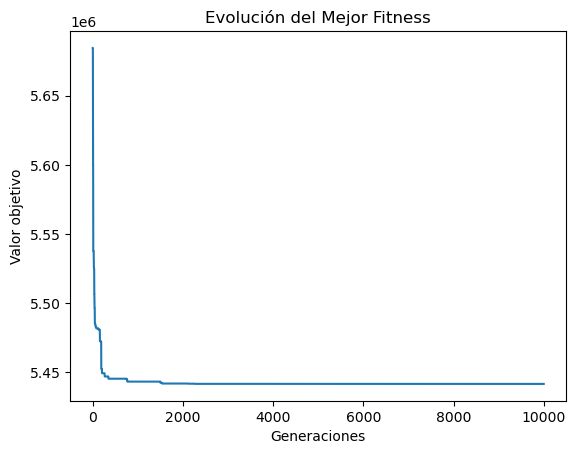

True

In [171]:
start_time = time.time()
mejorSoluciones, mejoresCostos = GA(instanciaQAP, 50, 0.01, 10000, "uniform", elite_ratio=0.1)
end_time = time.time()
execution_time = end_time - start_time
print("Solución conocida: ", 5426670)
print("La solución:", mejorSoluciones)
print("El fitness de la mejor solución:", min(mejoresCostos))
print("Tiempo de ejecución:", execution_time, "segundos")
graficar(mejoresCostos)

#### One Point Method

Solución conocida:  5426670
La solución: [13 12 11 23  6 15 25  1  0  8  7 18  4 20  2 21  9  5 19 10 14 16  3 22
 24 17]
El fitness de la mejor solución: 5433836
Tiempo de ejecución: 237.67986369132996 segundos


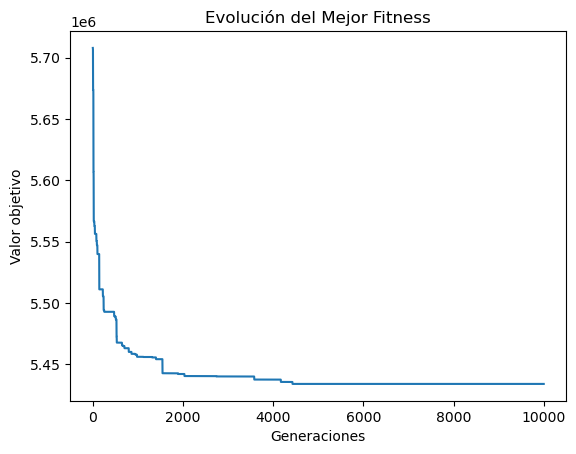

True

In [172]:
start_time = time.time()
mejorSoluciones, mejoresCostos = GA(instanciaQAP, 50, 0.01, 10000, elite_ratio=0.1)
end_time = time.time()
execution_time = end_time - start_time
print("Solución conocida: ", 5426670)
print("La solución:", mejorSoluciones)
print("El fitness de la mejor solución:", min(mejoresCostos))
print("Tiempo de ejecución:", execution_time, "segundos")
graficar(mejoresCostos)

#### Two Point Method

Solución conocida:  5426670
La solución: [16 21 15  2  8  3 13 19 23 18  5  9  1  4 11 12  7 14 20 17 25 24  0 10
 22  6]
El fitness de la mejor solución: 5471700
Tiempo de ejecución: 238.43919587135315 segundos


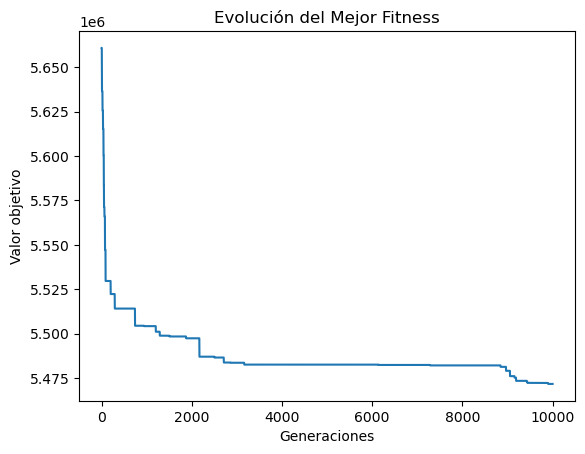

True

In [173]:
start_time = time.time()
mejorSoluciones, mejoresCostos = GA(instanciaQAP, 50, 0.01, 10000, "twopoint", elite_ratio=0.1)
end_time = time.time()
execution_time = end_time - start_time
print("Solución conocida: ", 5426670)
print("La solución:", mejorSoluciones)
print("El fitness de la mejor solución:", min(mejoresCostos))
print("Tiempo de ejecución:", execution_time, "segundos")
graficar(mejoresCostos)

#### Heuristic Method

Solución conocida:  5426670
La solución: [11  4 12  7  2  3 25  1  0  6 19 20 18 21 13 15  9  5 14 22 10 23  8 24
 17 16]
El fitness de la mejor solución: 5441538
Tiempo de ejecución: 292.43914794921875 segundos


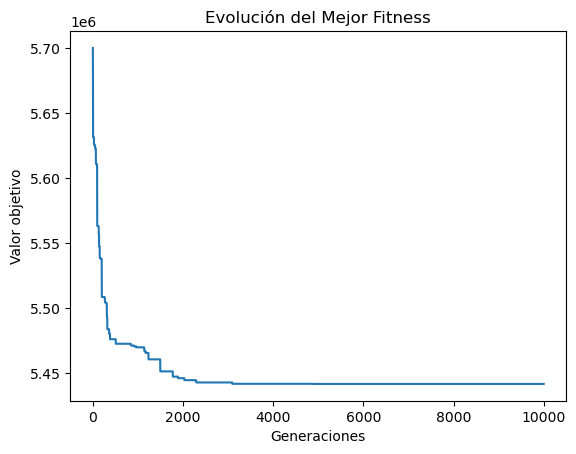

True

In [174]:
start_time = time.time()
mejorSoluciones, mejoresCostos = GA(instanciaQAP, 50, 0.01, 10000, "heuristic", elite_ratio=0.1)
end_time = time.time()
execution_time = end_time - start_time
print("Solución conocida: ", 5426670)
print("La solución:", mejorSoluciones)
print("El fitness de la mejor solución:", min(mejoresCostos))
print("Tiempo de ejecución:", execution_time, "segundos")
graficar(mejoresCostos)

### Ciclo 2: bur26b.dat (3817852)

In [175]:
nInstalaciones,matrizF,matrizD, = leerArchivo('./bur26b.dat')
matrizD2 = np.array(matrizD)
matrizF2 = np.array(matrizF)
instanciaQAP = QAP(matrizD2, matrizF2)

#### Uniform

Solución conocida:  3817852
La solución: [17 23 25 11  8 22  0 12 14 18  5 20  1  9 21  6 19  7  3 15  4 24 16 10
  2 13]
El fitness de la mejor solución: 3830725
Tiempo de ejecución: 243.89853811264038 segundos


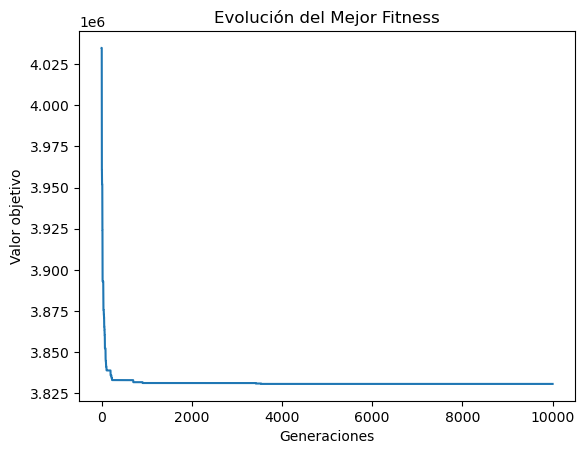

True

In [176]:
start_time = time.time()
mejorSoluciones, mejoresCostos = GA(instanciaQAP, 50, 0.01, 10000, "uniform", elite_ratio=0.1)
end_time = time.time()
execution_time = end_time - start_time
print("Solución conocida: ", 3817852)
print("La solución:", mejorSoluciones)
print("El fitness de la mejor solución:", min(mejoresCostos))
print("Tiempo de ejecución:", execution_time, "segundos")
graficar(mejoresCostos)

#### OnePoint Method


Solución conocida:  3817852
La solución: [ 0  2  6 13 12  3 17 16 15  1  7  4 19 18 14 21  9 20  5  8 11 22 23 10
 24 25]
El fitness de la mejor solución: 3833042
Tiempo de ejecución: 238.4405288696289 segundos


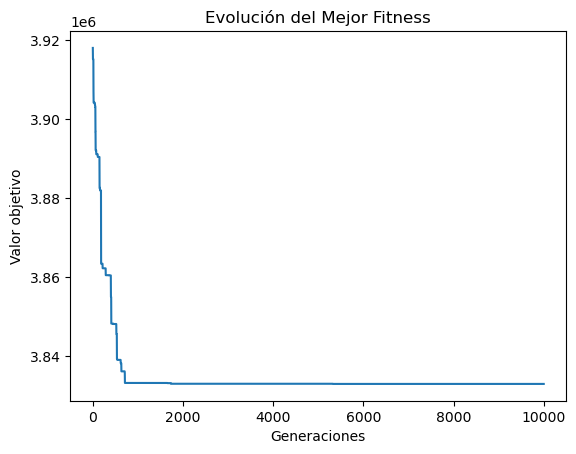

True

In [177]:
start_time = time.time()
mejorSoluciones, mejoresCostos = GA(instanciaQAP, 50, 0.01, 10000, elite_ratio=0.1)
end_time = time.time()
execution_time = end_time - start_time
print("Solución conocida: ", 3817852)
print("La solución:", mejorSoluciones)
print("El fitness de la mejor solución:", min(mejoresCostos))
print("Tiempo de ejecución:", execution_time, "segundos")
graficar(mejoresCostos)

#### Two Point Method

Solución conocida:  3817852
La solución: [ 6 13  2 24 14 10  8 11 15 21 12 18 20  1  3  4 19  9  5 23  0 16 22 17
 25  7]
El fitness de la mejor solución: 3843049
Tiempo de ejecución: 229.26559209823608 segundos


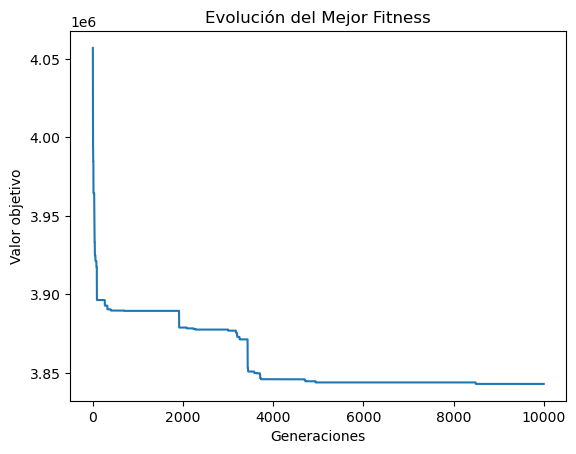

True

In [178]:
start_time = time.time()
mejorSoluciones, mejoresCostos = GA(instanciaQAP, 50, 0.01, 10000, "twopoint", elite_ratio=0.1)
end_time = time.time()
execution_time = end_time - start_time
print("Solución conocida: ", 3817852)
print("La solución:", mejorSoluciones)
print("El fitness de la mejor solución:", min(mejoresCostos))
print("Tiempo de ejecución:", execution_time, "segundos")
graficar(mejoresCostos)

#### Heuristic Method

Solución conocida:  3817852
La solución: [24 16  0 10  4 18 13  2 22 14  5 21  1  9  7  6  3 20 19 15 23 25  8 11
 12 17]
El fitness de la mejor solución: 3825601
Tiempo de ejecución: 289.2166256904602 segundos


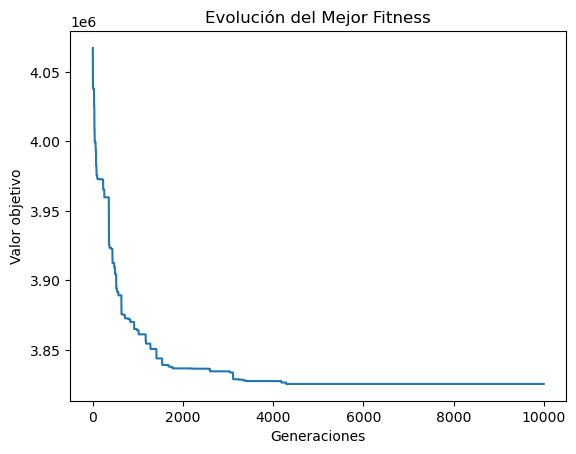

True

In [179]:
start_time = time.time()
mejorSoluciones, mejoresCostos = GA(instanciaQAP, 50, 0.01, 10000, "heuristic", elite_ratio=0.1)
end_time = time.time()
execution_time = end_time - start_time
print("Solución conocida: ", 3817852)
print("La solución:", mejorSoluciones)
print("El fitness de la mejor solución:", min(mejoresCostos))
print("Tiempo de ejecución:", execution_time, "segundos")
graficar(mejoresCostos) 

### Ciclo 3: bur26e.dat (5386879)

In [180]:
nInstalaciones,matrizF,matrizD  = leerArchivo('./bur26e.dat')
matrizD2 = np.array(matrizD)
matrizF2 = np.array(matrizF)
instanciaQAP = QAP(matrizD2, matrizF2)

#### Uniform

Solución conocida:  5386879
La solución: [ 7 13 16 12  4 25  0  1 17  8 19 20  3 18 14  9 21 15  5 22  6  2 24 10
 11 23]
El fitness de la mejor solución: 5405485
Tiempo de ejecución: 204.23117899894714 segundos


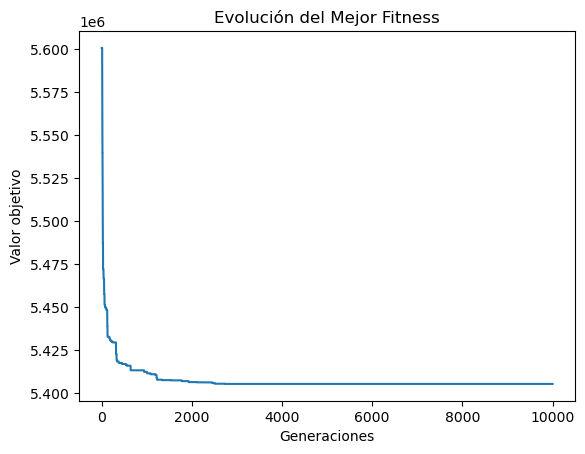

True

In [181]:
start_time = time.time()
mejorSoluciones, mejoresCostos = GA(instanciaQAP, 50, 0.01, 10000, "uniform", elite_ratio=0.1)
end_time = time.time()
execution_time = end_time - start_time
print("Solución conocida: ", 5386879)
print("La solución:", mejorSoluciones)
print("El fitness de la mejor solución:", min(mejoresCostos))
print("Tiempo de ejecución:", execution_time, "segundos")
graficar(mejoresCostos)

#### OnePoint Method


Solución conocida:  5386879
La solución: [ 2  1 25 17  4 16 13 12  6 14 21  5  9 15  7  3 19 18 20  8 23 10 11  0
 22 24]
El fitness de la mejor solución: 5401797
Tiempo de ejecución: 206.8169138431549 segundos


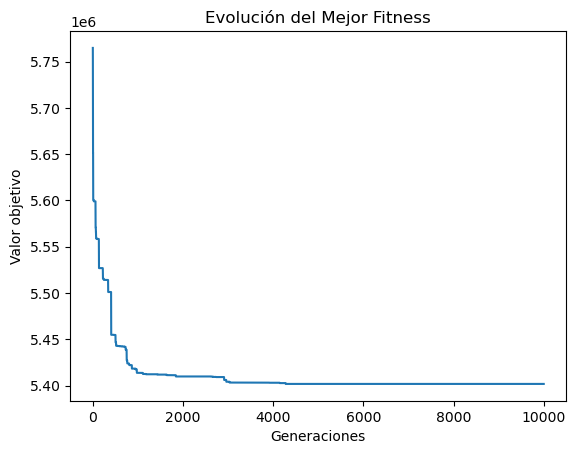

True

In [182]:
start_time = time.time()
mejorSoluciones, mejoresCostos = GA(instanciaQAP, 50, 0.01, 10000, elite_ratio=0.1)
end_time = time.time()
execution_time = end_time - start_time
print("Solución conocida: ", 5386879)
print("La solución:", mejorSoluciones)
print("El fitness de la mejor solución:", min(mejoresCostos))
print("Tiempo de ejecución:", execution_time, "segundos")
graficar(mejoresCostos)

#### Two Point Method

Solución conocida:  5386879
La solución: [14  4  6 22 18  1 15 23  8  2 16 20  3 19 17  7  5 21  9 12 25 13 10 24
  0 11]
El fitness de la mejor solución: 5429755
Tiempo de ejecución: 210.43200588226318 segundos


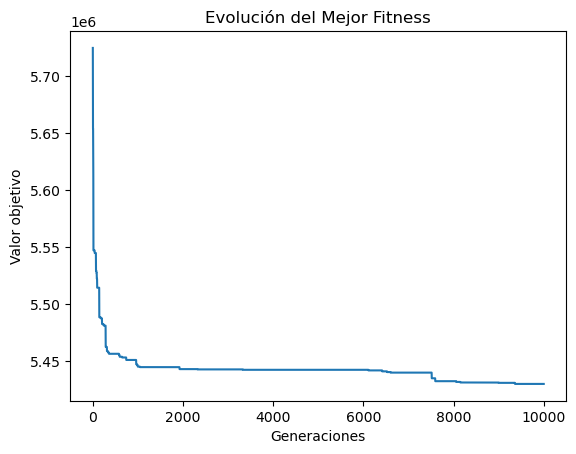

True

In [183]:
start_time = time.time()
mejorSoluciones, mejoresCostos = GA(instanciaQAP, 50, 0.01, 10000, "twopoint", elite_ratio=0.1)
end_time = time.time()
execution_time = end_time - start_time
print("Solución conocida: ", 5386879)
print("La solución:", mejorSoluciones)
print("El fitness de la mejor solución:", min(mejoresCostos))
print("Tiempo de ejecución:", execution_time, "segundos")
graficar(mejoresCostos)

#### Heuristic Method

Solución conocida:  5386879
La solución: [21  3 25 13 18 15  2 11  4 16 12 14  9 19  8  7  1  5 20  6 22 10 23  0
 17 24]
El fitness de la mejor solución: 5461599
Tiempo de ejecución: 288.94416093826294 segundos


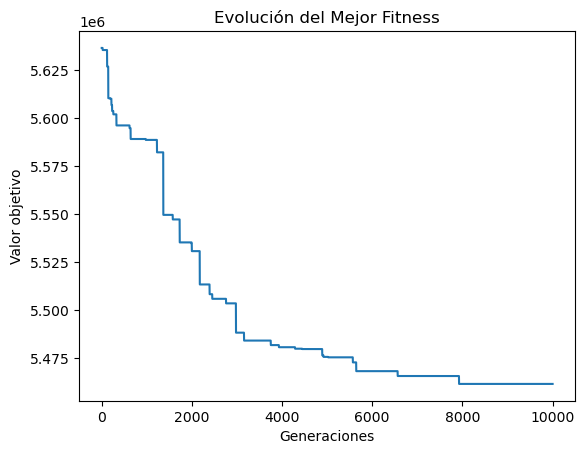

True

In [134]:
start_time = time.time()
mejorSoluciones, mejoresCostos = GA(instanciaQAP, 50, 0.01, 10000, "heuristic", elite_ratio=0.1)
end_time = time.time()
execution_time = end_time - start_time
print("Solución conocida: ", 5386879)
print("La solución:", mejorSoluciones)
print("El fitness de la mejor solución:", min(mejoresCostos))
print("Tiempo de ejecución:", execution_time, "segundos")
graficar(mejoresCostos)

### Ciclo 4: chr12a.dat (9552)

In [140]:
nInstalaciones,matrizF,matrizD, = leerArchivo('./chr12a.dat')
matrizD2 = np.array(matrizD)
matrizF2 = np.array(matrizF)
instanciaQAP = QAP(matrizD2, matrizF2)

#### Uniform

Solución conocida:  9552
La solución: [ 6 11  9  0  4  8  2  7 10  5  1  3]
El fitness de la mejor solución: 11646
Tiempo de ejecución: 54.1260449886322 segundos


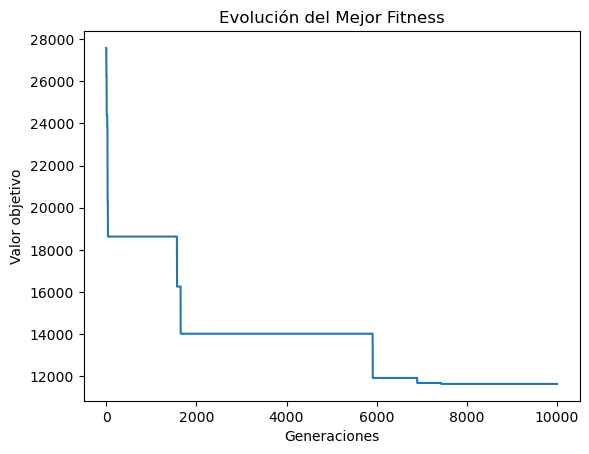

True

In [142]:
start_time = time.time()
mejorSoluciones, mejoresCostos = GA(instanciaQAP, 50, 0.01, 10000, "uniform", elite_ratio=0.1)
end_time = time.time()
execution_time = end_time - start_time
print("Solución conocida: ", 9552)
print("La solución:", mejorSoluciones)
print("El fitness de la mejor solución:", min(mejoresCostos))
print("Tiempo de ejecución:", execution_time, "segundos")
graficar(mejoresCostos)

#### OnePoint Method


Solución conocida:  9552
La solución: [11  5  4  8  6  3  2  1  0  7  9 10]
El fitness de la mejor solución: 11944
Tiempo de ejecución: 55.215275049209595 segundos


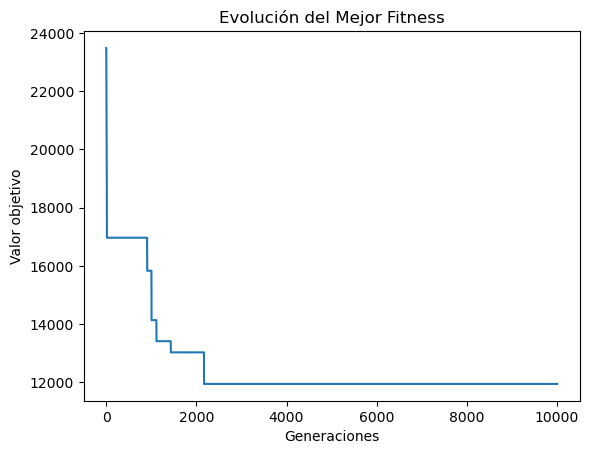

True

In [143]:
start_time = time.time()
mejorSoluciones, mejoresCostos = GA(instanciaQAP, 50, 0.01, 10000, elite_ratio=0.1)
end_time = time.time()
execution_time = end_time - start_time
print("Solución conocida: ", 9552)
print("La solución:", mejorSoluciones)
print("El fitness de la mejor solución:", min(mejoresCostos))
print("Tiempo de ejecución:", execution_time, "segundos")
graficar(mejoresCostos)

#### Two Point Method

Solución conocida:  9552
La solución: [ 7  5  4 10  1  3  2  6  0 11  9  8]
El fitness de la mejor solución: 10214
Tiempo de ejecución: 58.21622395515442 segundos


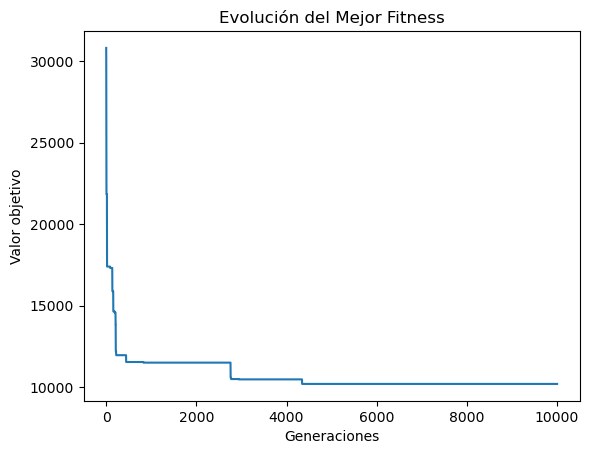

True

In [144]:
start_time = time.time()
mejorSoluciones, mejoresCostos = GA(instanciaQAP, 50, 0.01, 10000, "twopoint", elite_ratio=0.1)
end_time = time.time()
execution_time = end_time - start_time
print("Solución conocida: ", 9552)
print("La solución:", mejorSoluciones)
print("El fitness de la mejor solución:", min(mejoresCostos))
print("Tiempo de ejecución:", execution_time, "segundos")
graficar(mejoresCostos)

#### Heuristic Method

Solución conocida:  9552
La solución: [ 1  7  5  8  4 10  3 11  2  6  9  0]
El fitness de la mejor solución: 13850
Tiempo de ejecución: 91.5106418132782 segundos


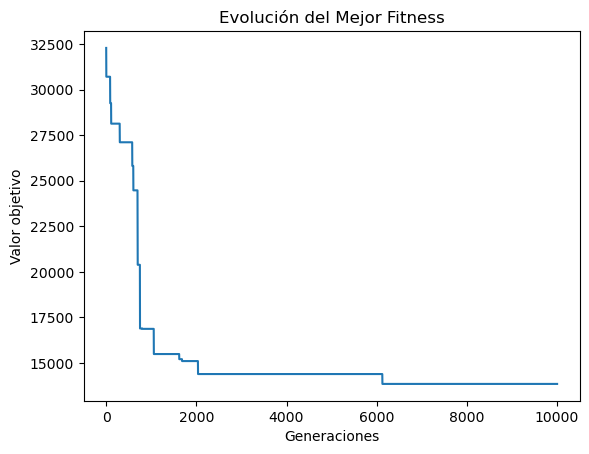

True

In [145]:
start_time = time.time()
mejorSoluciones, mejoresCostos = GA(instanciaQAP, 50, 0.01, 10000, "heuristic", elite_ratio=0.1)
end_time = time.time()
execution_time = end_time - start_time
print("Solución conocida: ", 9552)
print("La solución:", mejorSoluciones)
print("El fitness de la mejor solución:", min(mejoresCostos))
print("Tiempo de ejecución:", execution_time, "segundos")
graficar(mejoresCostos)

### Ciclo 5: chr15c.dat (9504)

In [146]:
nInstalaciones,matrizF,matrizD, = leerArchivo('./chr15c.dat')
matrizD2 = np.array(matrizD)
matrizF2 = np.array(matrizF)
instanciaQAP = QAP(matrizD2, matrizF2)

#### Uniform

Solución conocida:  9504
La solución: [10 11 12  9  3 13  6  2  0  7  4  1  5 14  8]
El fitness de la mejor solución: 13858
Tiempo de ejecución: 78.61016702651978 segundos


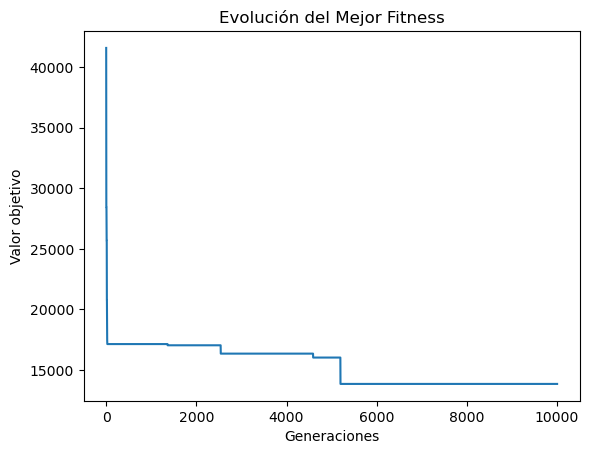

True

In [147]:
start_time = time.time()
mejorSoluciones, mejoresCostos = GA(instanciaQAP, 50, 0.01, 10000, "uniform", elite_ratio=0.1)
end_time = time.time()
execution_time = end_time - start_time
print("Solución conocida: ", 9504)
print("La solución:", mejorSoluciones)
print("El fitness de la mejor solución:", min(mejoresCostos))
print("Tiempo de ejecución:", execution_time, "segundos")
graficar(mejoresCostos)

#### OnePoint Method


Solución conocida:  9504
La solución: [11 10  9 12  1  3 14 13  0  7  4  2  5  6  8]
El fitness de la mejor solución: 13640
Tiempo de ejecución: 78.62310695648193 segundos


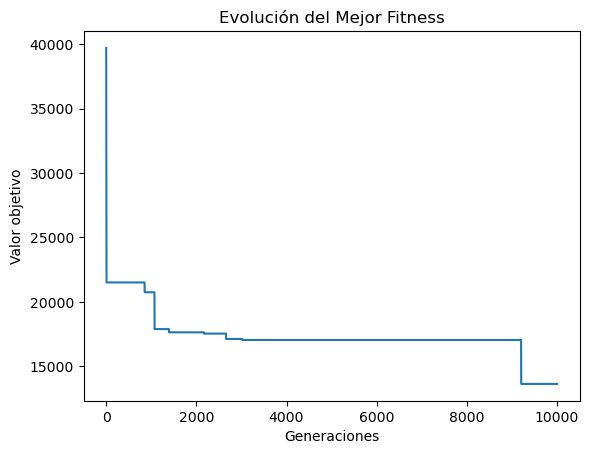

True

In [148]:
start_time = time.time()
mejorSoluciones, mejoresCostos = GA(instanciaQAP, 50, 0.01, 10000, elite_ratio=0.1)
end_time = time.time()
execution_time = end_time - start_time
print("Solución conocida: ", 9504)
print("La solución:", mejorSoluciones)
print("El fitness de la mejor solución:", min(mejoresCostos))
print("Tiempo de ejecución:", execution_time, "segundos")
graficar(mejoresCostos)

#### Two Point Method

Solución conocida:  9504
La solución: [ 8 12 14 10  1  5  6 13  2  3  7  9  4 11  0]
El fitness de la mejor solución: 14728
Tiempo de ejecución: 82.22386717796326 segundos


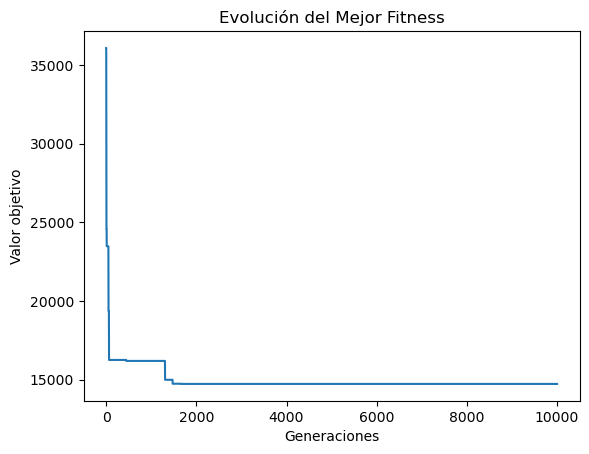

True

In [149]:
start_time = time.time()
mejorSoluciones, mejoresCostos = GA(instanciaQAP, 50, 0.01, 10000, "twopoint", elite_ratio=0.1)
end_time = time.time()
execution_time = end_time - start_time
print("Solución conocida: ", 9504)
print("La solución:", mejorSoluciones)
print("El fitness de la mejor solución:", min(mejoresCostos))
print("Tiempo de ejecución:", execution_time, "segundos")
graficar(mejoresCostos)

#### Heuristic Method

Solución conocida:  9504
La solución: [ 2 10  7 12  1 14  6  3  8 13  5  9  4 11  0]
El fitness de la mejor solución: 14426
Tiempo de ejecución: 123.34824299812317 segundos


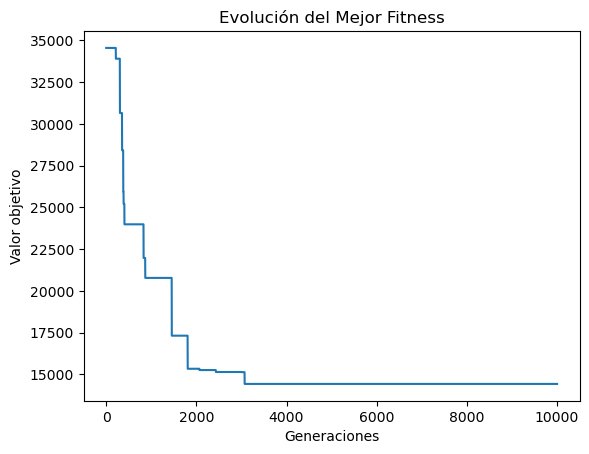

True

In [150]:
start_time = time.time()
mejorSoluciones, mejoresCostos = GA(instanciaQAP, 50, 0.01, 10000, "heuristic", elite_ratio=0.1)
end_time = time.time()
execution_time = end_time - start_time
print("Solución conocida: ", 9504)
print("La solución:", mejorSoluciones)
print("El fitness de la mejor solución:", min(mejoresCostos))
print("Tiempo de ejecución:", execution_time, "segundos")
graficar(mejoresCostos)

### Ciclo 6: chr18a.dat (11098)

In [151]:
nInstalaciones,matrizF,matrizD, = leerArchivo('./chr18a.dat')
matrizD2 = np.array(matrizD)
matrizF2 = np.array(matrizF)
instanciaQAP = QAP(matrizD2, matrizF2)

#### Uniform

Solución conocida:  11098
La solución: [ 1 17  7 13 12  0 16  3  9  6  4 15  5 10  2  8 11 14]
El fitness de la mejor solución: 16258
Tiempo de ejecución: 121.77348709106445 segundos


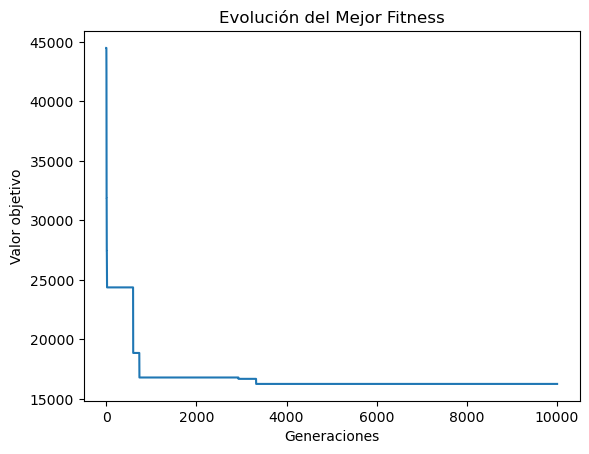

True

In [152]:
start_time = time.time()
mejorSoluciones, mejoresCostos = GA(instanciaQAP, 50, 0.01, 10000, "uniform", elite_ratio=0.1)
end_time = time.time()
execution_time = end_time - start_time
print("Solución conocida: ", 11098)
print("La solución:", mejorSoluciones)
print("El fitness de la mejor solución:", min(mejoresCostos))
print("Tiempo de ejecución:", execution_time, "segundos")
graficar(mejoresCostos)

#### OnePoint Method


Solución conocida:  11098
La solución: [ 9  5  8  7 13 14  2 12  4  0  1  3 10 11 16 15 17  6]
El fitness de la mejor solución: 18662
Tiempo de ejecución: 122.52433609962463 segundos


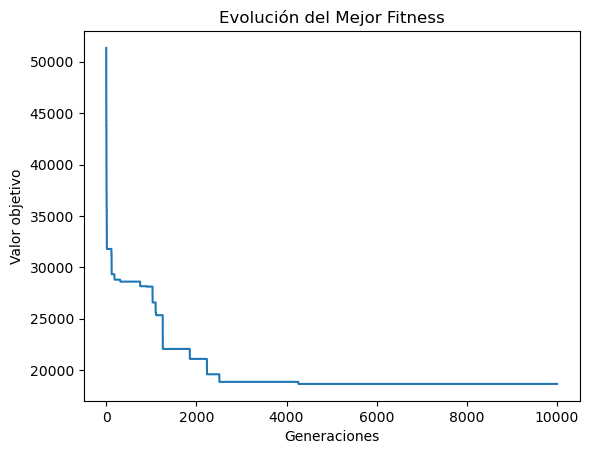

True

In [153]:
start_time = time.time()
mejorSoluciones, mejoresCostos = GA(instanciaQAP, 50, 0.01, 10000, elite_ratio=0.1)
end_time = time.time()
execution_time = end_time - start_time
print("Solución conocida: ", 11098)
print("La solución:", mejorSoluciones)
print("El fitness de la mejor solución:", min(mejoresCostos))
print("Tiempo de ejecución:", execution_time, "segundos")
graficar(mejoresCostos)

#### Two Point Method

Solución conocida:  11098
La solución: [ 8  5  7  0 12  1  9  6 16 15  3 17  2 13  4 11 10 14]
El fitness de la mejor solución: 16098
Tiempo de ejecución: 247.34632682800293 segundos


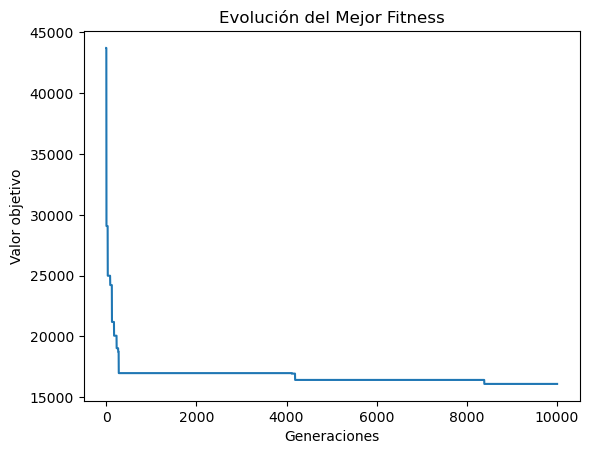

True

In [163]:
start_time = time.time()
mejorSoluciones, mejoresCostos = GA(instanciaQAP, 100, 0.01, 10000, "twopoint", elite_ratio=0.1)
end_time = time.time()
execution_time = end_time - start_time
print("Solución conocida: ", 11098)
print("La solución:", mejorSoluciones)
print("El fitness de la mejor solución:", min(mejoresCostos))
print("Tiempo de ejecución:", execution_time, "segundos")
graficar(mejoresCostos)

#### Heuristic Method

Solución conocida:  11098
La solución: [ 3  6 13  4 15 16 10  5  1 12  8 17  2  7  9 11  0 14]
El fitness de la mejor solución: 13454
Tiempo de ejecución: 161.05928587913513 segundos


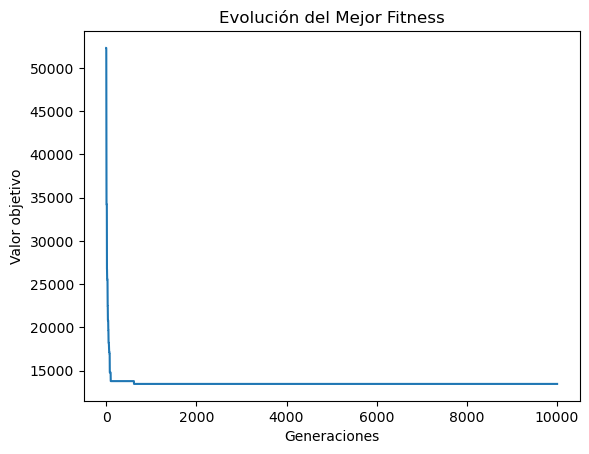

True

In [162]:
start_time = time.time()
mejorSoluciones, mejoresCostos = GA(instanciaQAP, 50, 0.01, 10000, "heuristic", elite_ratio=0.1)
end_time = time.time()
execution_time = end_time - start_time
print("Solución conocida: ", 11098)
print("La solución:", mejorSoluciones)
print("El fitness de la mejor solución:", min(mejoresCostos))
print("Tiempo de ejecución:", execution_time, "segundos")
graficar(mejoresCostos)